<h1> <a href=http://www.datascience-paris-saclay.fr/>Paris Saclay Center for Data Science</a> </h1>

<h2> Titanic RAMP: survival prediction of Titanic passengers </h2>

<i> Benoit Playe (Institut Curie/Mines ParisTech), Chloé-Agathe Azencott (Institut Curie/Mines ParisTech), Alex Gramfort (LTCI/Télécom ParisTech), Balázs Kégl (LAL/CNRS)</i>

<h2> Introduction </h2>
This is an initiation project to introduce RAMP and make you comfortable with its functioning.

The goal is to develop prediction models able to <b> identify people who survived from the sinking of the Titanic, based on gender, age, and ticketing information</b>.  

The data we will manipulate is from the <a href=https://www.kaggle.com/c/titanic-gettingStarted>Titanic kaggle challenge</a>.

### Requirements

* numpy>=1.10.0  
* matplotlib>=1.5.0 
* pandas>=0.19.0  
* scikit-learn>=0.17 (different syntaxes for v0.17 and v0.18)   
* seaborn>=0.7.1

In [1]:
%matplotlib inline
import os
import glob
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import pandas as pd

## Exploratory data analysis

### Loading the data

In [2]:
train_filename = 'data/train.csv'
data = pd.read_csv(train_filename)
y_df = data['Survived']
X_df = data.drop(['Survived', 'PassengerId'], axis=1)
X_df.head(5)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,2,"Becker, Master. Richard F",male,1.0,2,1,230136,39.0000,F4,S
1,3,"Nankoff, Mr. Minko",male,NaN,0,0,349218,7.8958,NaN,S
2,3,"Zabour, Miss. Thamine",female,NaN,1,0,2665,14.4542,NaN,C
3,2,"Keane, Miss. Nora A",female,NaN,0,0,226593,12.3500,E101,Q
4,2,"Butler, Mr. Reginald Fenton",male,25.0,0,0,234686,13.0000,NaN,S


In [3]:
data.describe()

/Users/kegl/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,569.000000,569.000000,569.000000,448.000000,569.000000,569.000000,569.000000
mean,439.945518,0.393673,2.297012,30.237366,0.521968,0.360281,33.277664
std,258.100473,0.488994,0.835823,14.686785,1.135204,0.790728,54.930709
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,218.000000,0.000000,2.000000,NaN,0.000000,0.000000,7.895800
50%,440.000000,0.000000,3.000000,NaN,0.000000,0.000000,13.500000
75%,662.000000,1.000000,3.000000,NaN,1.000000,0.000000,31.387500
max,889.000000,1.000000,3.000000,80.000000,8.000000,5.000000,512.329200


In [4]:
data.count()

PassengerId    569
Survived       569
Pclass         569
Name           569
Sex            569
Age            448
SibSp          569
Parch          569
Ticket         569
Fare           569
Cabin          132
Embarked       567
dtype: int64

The data frame has 891 rows. Some passengers have missing information though: in particular Age and Cabin info can be missing. The meaning of the columns is explained on the challenge website:

https://www.kaggle.com/c/titanic-gettingStarted/data

### Predicting survival

The goal is to predict whether a passenger has survived from others known attribute. Let us group the data according to the `Survived` columns:

In [5]:
data.groupby('Survived').count()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Survived,,,,,,,,,,,
0,345,345,345,345,259,345,345,345,345,46,345
1,224,224,224,224,189,224,224,224,224,86,222


About two thirds of the passengers perished in the event. A dummy classifier that systematically returns "0" would have an accuracy of 62%, higher than that of a random model.

### Some plots

#### Features densities and co-evolution
A scatterplot matrix allows us to visualize:
* on the diagonal, the density estimation for each of the features
* on each of the off-diagonal plots, a scatterplot between two of the features. Each dot represents a sample.

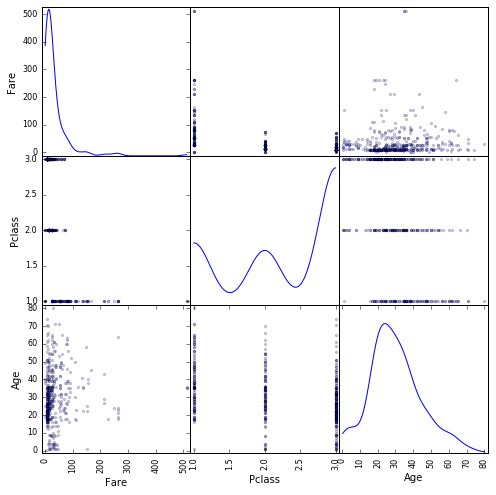

In [6]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(data.get(['Fare', 'Pclass', 'Age']), alpha=0.2,
               figsize=(8, 8), diagonal='kde');

#### Non-linearly transformed data

The 'Fare' variable has a very heavy tail. We can log-transform it. 

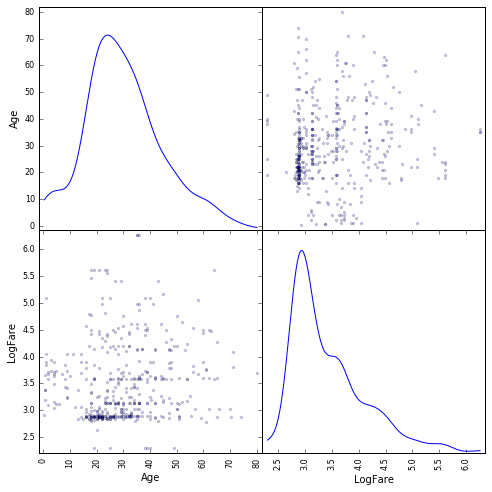

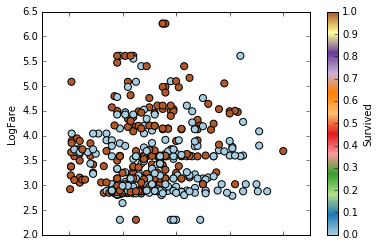

In [7]:
data_plot = data.get(['Age', 'Survived'])
data_plot = data.assign(LogFare=lambda x : np.log(x.Fare + 10.))
scatter_matrix(data_plot.get(['Age', 'LogFare']), alpha=0.2, figsize=(8, 8), diagonal='kde');

data_plot.plot(kind='scatter', x='Age', y='LogFare', c='Survived', s=50, cmap=plt.cm.Paired);

#### Plot of two variables bivariate and univariate distributions

Another way of visualizing relationships between variables is to plot their bivariate distributions.

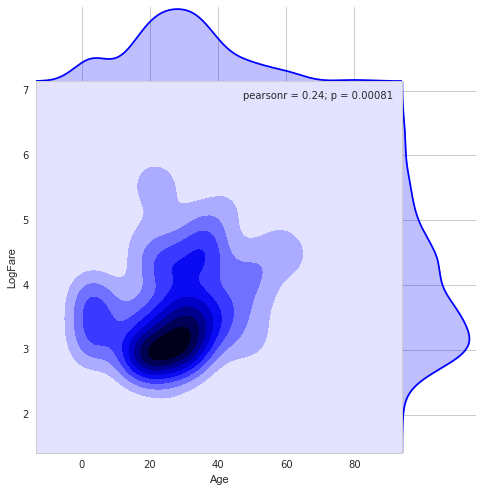

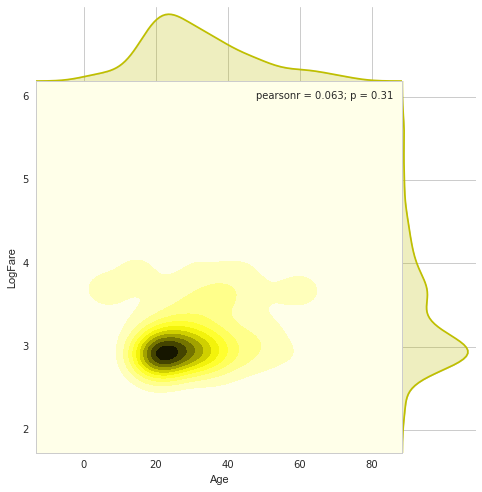

In [8]:
import seaborn as sns

sns.set()
sns.set_style("whitegrid")
sns.jointplot(data_plot.Age[data_plot.Survived == 1],
              data_plot.LogFare[data_plot.Survived == 1],
              kind="kde", size=7, space=0, color="b");

sns.jointplot(data_plot.Age[data_plot.Survived == 0],
              data_plot.LogFare[data_plot.Survived == 0],
              kind="kde", size=7, space=0, color="y");

## Submission

For your submissions, you have to write 2 classes, saved in 2 different files:   
* the class <code>FeatureExtractor</code>, which will be used to extract features for classification from the dataset and produce a numpy array of size (number of samples, dim of features).  
* a class <code>Classifier</code> to predict survival 

When submitting these files, they are uploaded to our servers and run to give you a score!  

### Feature extractor

The feature extractor for classification is implemented by the function <code>transform</code> and is saved in the file [<code>submissions/starting_kit/feature_extractor.py</code>](http://localhost:8890/edit/submissions/starting_kit/feature_extractor.py). It receives the pandas dataframe <code>X_df</code> defined at the beginning of the notebook. It should produce a numpy array representing the features extracted, which would be used for the classification.  

Below is an example of a feature extractor. You can copy-paste it into your [<code>feature_extractor.py</code>](http://localhost:8890/edit/submissions/starting_kit/feature_extractor.py) file or write a new one!

In [ ]:
# %load submissions/starting_kit/feature_extractor.py
import pandas as pd


class FeatureExtractor():
    def __init__(self):
        pass

    def fit(self, X_df, y):
        pass

    def transform(self, X_df):
        X_df_new = pd.concat(
            [X_df.get(['Fare', 'Age', 'SibSp', 'Parch']),
             pd.get_dummies(X_df.Sex, prefix='Sex', drop_first=True),
             pd.get_dummies(X_df.Pclass, prefix='Pclass', drop_first=True),
             pd.get_dummies(X_df.Embarked, prefix='Embarked',
                            drop_first=True)],
            axis=1)
        X_df_new = X_df_new.fillna(-1)
        XX = X_df_new.values
        return XX


### Classifier

The classifier follows a classical scikit-learn classifier template. It should be saved in the file [<code>submissions/starting_kit/classifier.py</code>](http://localhost:8890/edit/submissions/starting_kit/classifier.py). In its simplest form it takes a scikit-learn pipeline and assignes it to <code>self.clf</code> in <code>__init__</code>.

In [ ]:
# %load submissions/starting_kit/classifier.py
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator


class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = Pipeline([
            ('imputer', Imputer(strategy='median')),
            ('classifier', LogisticRegression(C=1.))
        ])

    def fit(self, X, y):
        self.clf.fit(X, y)

    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)


## Unit testing

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. For this we provide a unit test. First <code>pip install ramp-workflow</code> or [clone it from git](https://github.com/paris-saclay-cds/ramp-workflow). Then make sure that the python files [<code>feature_extractor.py</code>](http://localhost:8890/edit/submissions/starting_kit/feature_extractor.py) and [<code>classifier.py</code>](http://localhost:8890/edit/submissions/starting_kit/classifier.py) are in [<code>./submissions/starting_kit/</code>](http://localhost:8890/edit/submissions/starting_kit), and the data [<code>train.csv</code>](http://localhost:8890/edit/data/train.csv) and [<code>test.csv</code>](http://localhost:8890/edit/data/test.csv) are in [<code>./data/</code>](http://localhost:8890/edit/data). Then run

<code>test_submission</code>

If it runs and print training and test errors on each fold, then you can submit the code.

To run test_submission and test your code from the notebook you can do:

In [2]:
!test_submission

Testing Titanic survival classification
Reading train and test files from ./data ...
Training ./submissions/starting_kit ...
CV fold 0
	train auc = 0.84
	valid auc = 0.89
	test auc = 0.83
	train acc = 0.8
	valid acc = 0.85
	test acc = 0.76
	train nll = 0.46
	valid nll = 0.39
	test nll = 0.5
CV fold 1
	train auc = 0.85
	valid auc = 0.86
	test auc = 0.83
	train acc = 0.81
	valid acc = 0.8
	test acc = 0.76
	train nll = 0.44
	valid nll = 0.45
	test nll = 0.49
CV fold 2
	train auc = 0.85
	valid auc = 0.83
	test auc = 0.82
	train acc = 0.81
	valid acc = 0.79
	test acc = 0.76
	train nll = 0.44
	valid nll = 0.47
	test nll = 0.5
CV fold 3
	train auc = 0.84
	valid auc = 0.91
	test auc = 0.83
	train acc = 0.8
	valid acc = 0.82
	test acc = 0.76
	train nll = 0.46
	valid nll = 0.4
	test nll = 0.5
CV fold 4
	train auc = 0.85
	valid auc = 0.87
	test auc = 0.83
	train acc = 0.81
	valid acc = 0.81
	test acc = 0.76
	train nll = 0.45
	valid nll = 0.44
	test nll = 0.51
CV fold 5
	train auc = 0.84
	valid au